# 3D Beam Element Example - A Dome Structure

This example demonstrates how to use GMSH to create a 3D dome structure using beam elements. 
The original example can be found in [Elastic 3D beam structures using ``FEniCSx``](https://bleyerj.github.io/comet-fenicsx/tours/beams/beams_3D/beams_3D.html).

## Gmsh model

The GMSH model is shown in the figure below:

![image.png](https://s2.loli.net/2025/02/26/csYkWRgH8pe1FUb.png)

CODE:

In [1]:
import gmsh
import numpy as np

#
# Initialize gmsh
gmsh.initialize()
gmsh.model.add("dome")

# Parameters
N = 20
h = 10
a = 20
M = 20
d = 1.0  # mesh size

# Creating points and lines
p0 = gmsh.model.occ.addPoint(a, 0, 0, d)
lines = []

for i in range(1, N + 1):
    p1 = gmsh.model.occ.addPoint(
        a * np.cos(0.99 * i / N * np.pi / 2.0),
        0,
        h * np.sin(i / N * np.pi / 2.0),
        d,
    )
    ll = gmsh.model.occ.addLine(p0, p1)
    lines.append(ll)
    p0 = p1
in_lines = [(1, line) for line in lines]
# Extruding lines
for j in range(1, M + 1):
    out = gmsh.model.occ.revolve(
        in_lines,
        0,
        0,
        0,
        0,
        0,
        1,
        angle=2 * np.pi / M,
    )
    in_lines = out[::4]

# Coherence (remove duplicate entities and ensure topological consistency)
# gmsh.model.occ.dilate(entities, 0.0, 0.0, 0.0, 1, 0.1, 1)
# gmsh.model.occ.synchronize()
# Save the mesh
gmsh.model.occ.remove_all_duplicates()
gmsh.model.occ.synchronize()

#  Physical groups --lines
line_entities = gmsh.model.occ.getEntities(dim=1)

fixed_lines, all_lines = [], []
for entity in line_entities:
    line_tag = entity[1]
    all_lines.append(line_tag)
    node_tags = gmsh.model.getBoundary([entity], oriented=False)
    node_coords = [
        gmsh.model.getValue(dim=0, tag=node[1], parametricCoord=[])
        for node in node_tags
    ]
    z_coords = [coord[2] for coord in node_coords]
    if all(z == 0 for z in z_coords):
        fixed_lines.append(line_tag)
gmsh.model.addPhysicalGroup(1, fixed_lines, 2, "FixLines")
gmsh.model.addPhysicalGroup(1, all_lines, 1, "AllLines")

# We can then generate a 2D mesh...
gmsh.option.setNumber("Mesh.SaveAll", 1)
gmsh.model.mesh.generate(1)

gmsh.write("dome.msh")

# gmsh.fltk.run()  # Uncomment to visualize the mesh

# Finalize gmsh
gmsh.finalize()

## Gmsh model to openseespy

In [2]:
import openseespy.opensees as ops
import opstool as opst

ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 6)

### Read mesh

API: [opst.pre.Gmsh2OPS](https://opstool.readthedocs.io/en/stable/src/api/pre.html#opstool.pre.Gmsh2OPS)

In [3]:
GMSH_MODEL = opst.pre.Gmsh2OPS(ndm=3, ndf=6)
GMSH_MODEL.read_gmsh_file("dome.msh")
# GMSH_MODEL.get_physical_groups()
# GMSH_MODEL.get_dim_entity_tags()
# GMSH_MODEL.get_node_tags()

Info:: 2 Physical Names.
Info:: 2200 Nodes; MaxNodeTag 2200; MinNodeTag 1.
Info:: 3020 Elements; MaxEleTag 3020; MinEleTag 1.
Info:: Geometry Information >>>
1640 Entities: 420 Point; 820 Curves; 400 Surfaces; 0 Volumes.

Info:: Physical Groups Information >>>
2 Physical Groups.
Physical Group names: ['AllLines', 'FixLines']

Info:: Mesh Information >>>
2200 Nodes; MaxNodeTag 2200; MinNodeTag 1.
2600 Elements; MaxEleTag 3020; MinEleTag 421.



### create nodes

In [4]:
# Create nodes
node_tags = GMSH_MODEL.create_node_cmds()

### Create Fixed nodes

In [5]:
fix_tags = GMSH_MODEL.get_boundary_dim_tags(physical_group_names=["FixLines"],
                                            include_self=True)
fix_node_tags = GMSH_MODEL.get_node_tags(dim_entity_tags=fix_tags)
for ntag in fix_node_tags:
    ops.fix(ntag, 1, 1, 1, 1, 1, 1)

### Creating Elastic Beam-Column Elements

In [6]:
thick = 0.3
width = thick / 3
E = 70e3
nu = 0.3
G = E / 2 / (1 + nu)
rho = 2.7e-3

A = thick * width
Iy = E * width * thick**3 / 12
Iz = E * width**3 * thick / 12
J = 0.26 * thick * width**3
kappa = 5. / 6.

# element elasticBeamColumn $eleTag $iNode $jNode $A $E $G $J $Iy $Iz $transfTag
transfTag = 1
ops.geomTransf("Linear", transfTag, 0, 0, 1)
beam_args = [A, E, G, J, Iy, Iz, transfTag]

ele_tags = GMSH_MODEL.create_element_cmds(
    ops_ele_type="elasticBeamColumn",
    ops_ele_args=beam_args,
    physical_group_names=["AllLines"],
)

### Model Mass

Managing model mass with class ``opst.pre.ModelMass()``

In [7]:
g = 9.81
MODEL_MASS = opst.pre.ModelMass()
MODEL_MASS.add_mass_from_line(ele_tags=ele_tags, rho=rho, area=A)
MODEL_MASS.generate_ops_node_mass()
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
MODEL_MASS.generate_ops_gravity_load(direction="z", factor=-g)

### Model Geometry Visualization

OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

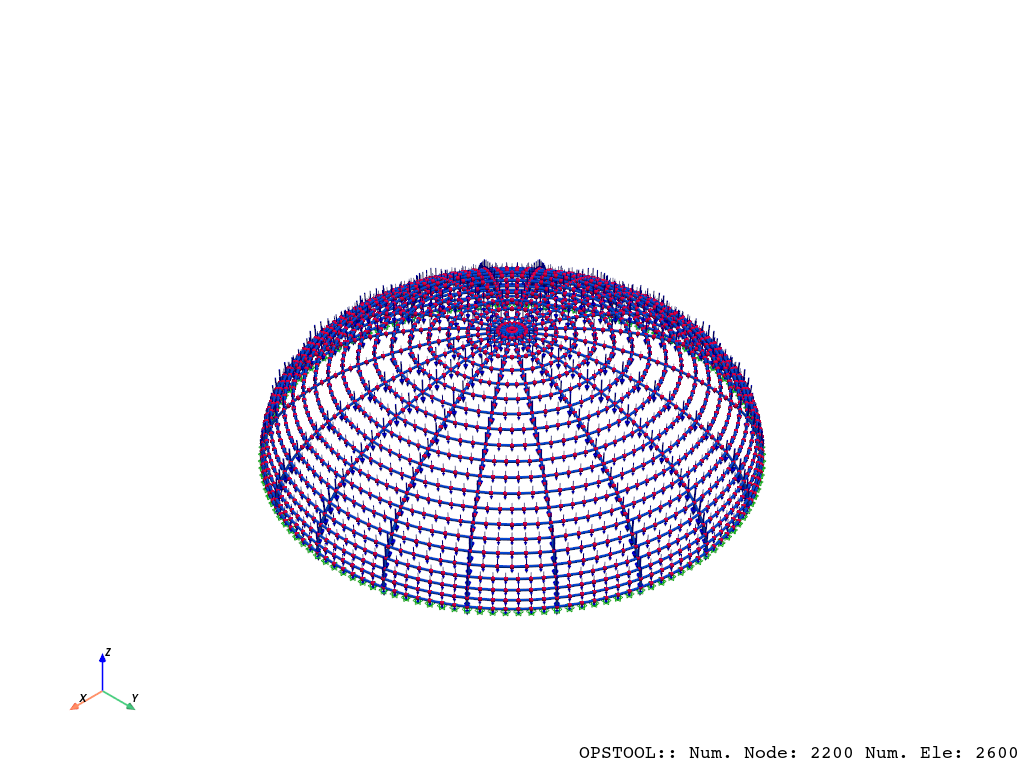

In [8]:
opst.vis.pyvista.set_plot_props(point_size=5, line_width=3, notebook=True)
opst.vis.pyvista.plot_model(show_nodal_loads=True).show(
    jupyter_backend="jupyterlab")

### Eigenvalue results visualization

Using DomainModalProperties - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


OPSTOOL ::  Eigen data has been saved to _OPSTOOL_ODB/EigenData-None.nc!

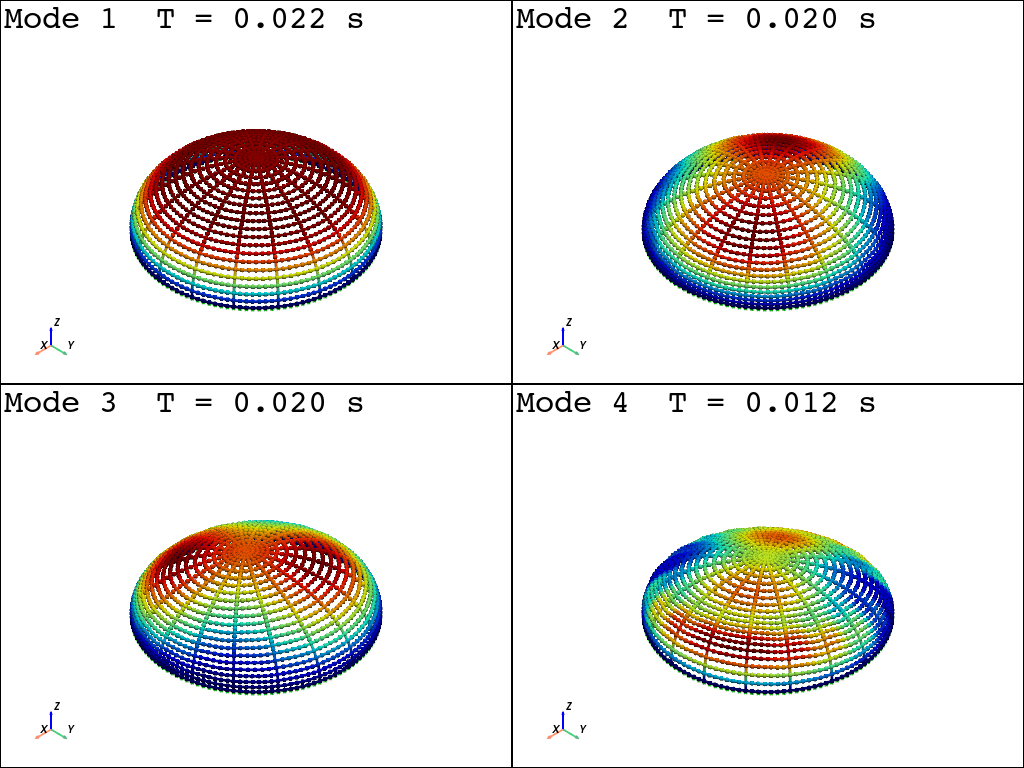

In [9]:
fig = opst.vis.pyvista.plot_eigen(mode_tags=[1, 4], subplots=True)
fig.show(jupyter_backend="jupyterlab")

### Gravity analysis and postprocessing

In [10]:
ops.wipeAnalysis()
ops.constraints("Transformation")
ops.numberer("RCM")
ops.system("BandGeneral")
ops.test("NormDispIncr", 1.0e-6, 6)
ops.algorithm("Newton")
ops.integrator("LoadControl", 0.1)
ops.analysis("Static")

In [11]:
ODB = opst.post.CreateODB(odb_tag="static")
for _ in range(10):
    ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()

OPSTOOL ::  All responses data with odb_tag = static saved in _OPSTOOL_ODB/RespStepData-static.nc!

For post-processing please see [Frame element Response](https://opstool.readthedocs.io/en/latest/src/post/frame_resp.html)

In [12]:
beam_resp = opst.post.get_element_responses(odb_tag="static", ele_type="Frame")
print(beam_resp)

OPSTOOL ::  Loading Frame None response data from _OPSTOOL_ODB/RespStepData-static.nc ...

<xarray.Dataset> Size: 51MB
Dimensions:              (time: 11, eleTags: 2600, localDofs: 12, basicDofs: 6,
                          secPoints: 15, secDofs: 6)
Coordinates:
  * eleTags              (eleTags) int32 10kB 421 422 423 424 ... 3018 3019 3020
  * localDofs            (localDofs) <U3 144B 'FX1' 'FY1' 'FZ1' ... 'MY2' 'MZ2'
  * basicDofs            (basicDofs) <U3 72B 'N' 'MZ1' 'MZ2' 'MY1' 'MY2' 'T'
  * secPoints            (secPoints) int32 60B 1 2 3 4 5 6 ... 10 11 12 13 14 15
  * secDofs              (secDofs) <U2 48B 'N' 'MZ' 'VY' 'MY' 'VZ' 'T'
  * time                 (time) float64 88B 0.0 0.1 0.2 0.3 ... 0.7 0.8 0.9 1.0
Data variables:
    localForces          (time, eleTags, localDofs) float64 3MB ...
    basicForces          (time, eleTags, basicDofs) float64 1MB ...
    basicDeformations    (time, eleTags, basicDofs) float64 1MB ...
    plasticDeformation   (time, eleTags, basicDofs) float64 1MB ...
    sectionForces        (time, eleTags, secPoints, secDofs) float64

OPSTOOL ::  Loading response data from _OPSTOOL_ODB/RespStepData-static.nc ...

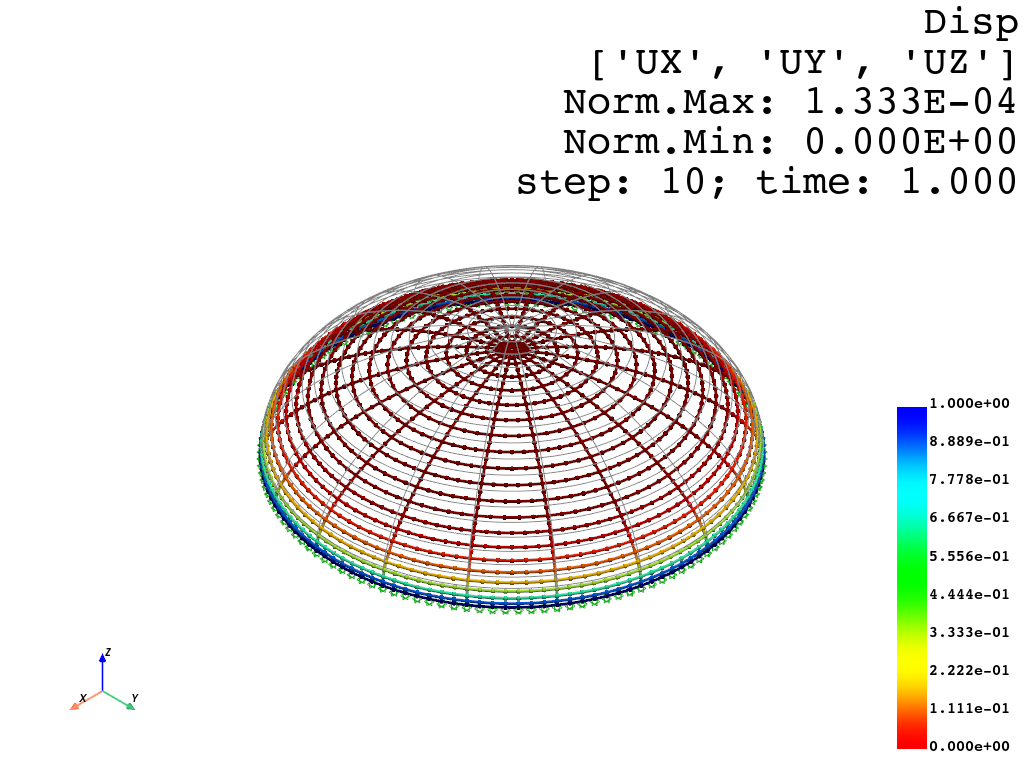

In [13]:
fig = opst.vis.pyvista.plot_nodal_responses(odb_tag="static",
                                            resp_type="disp",
                                            show_undeformed=True)
fig.show(jupyter_backend="jupyterlab")